In [73]:
%matplotlib inline
import math, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, operator
from importlib import reload

In [74]:
import kmeans; reload(kmeans)
from kmeans import Kmeans

In [75]:
n_clusters=6
n_samples =25000

In [76]:
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
           for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

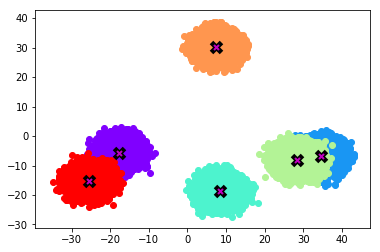

In [77]:
kmeans.plot_data(centroids, data, n_samples)

# Kmeans

In [78]:
k = Kmeans(data, n_clusters)

In [79]:
with tf.Session().as_default():
    %time new_centroids = k.run()

CPU times: user 740 ms, sys: 12 ms, total: 752 ms
Wall time: 760 ms


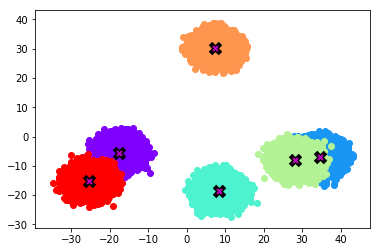

In [80]:
kmeans.plot_data(new_centroids, data, n_samples)

# Mean shift with LSH

In [81]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [82]:
def dist_b(a,b):
    return torch.sqrt((sub(a.unsqueeze(0),b.unsqueeze(1))**2).sum(2))

In [83]:
def sum_sqz(a,axis): return a.sum(axis).squeeze(axis)

In [84]:
import torch
from torch_utils import * 
from pytorch_lshash import PyTorchLSHash

def meanshift_lsh(data, bs=500):
    n = len(data)
    X = torch.FloatTensor(np.copy(data)).cuda()
    
    for it in range(5):
        pylsh = PyTorchLSHash(6, 2)
        pylsh.index(X)
        for i in range(0,n,bs):
            s = slice(i,min(n, i+bs))
            candidates = pylsh.query(s, X, bs)
            weight = gaussian(dist_b(candidates, X[s]), 2)
            num = sum_sqz(mul(weight, candidates), 1)
            X[s] = div(num, sum_sqz(weight, 1))
    return X

In [85]:
%time X=meanshift_lsh(data)

CPU times: user 5.02 s, sys: 672 ms, total: 5.69 s
Wall time: 5.69 s


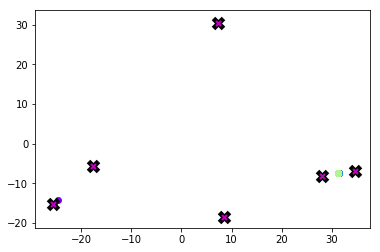

In [86]:
kmeans.plot_data(new_centroids, X.cpu().numpy(), n_samples)

# Meanshift with random draw

In [87]:
def meanshift_random(data, bs=500):
    n = len(data)
    X = torch.FloatTensor(np.copy(data)).cuda()
    
    for it in range(5):
        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            candidates = X[torch.randperm(len(X))[slice(0,bs)].long().cuda()]
            weight = gaussian(dist_b(candidates, X[s]), 2)
            num = sum_sqz(mul(weight, candidates), 1)
            X[s] = div(num, sum_sqz(weight, 1))
    return X

In [88]:
%time X=meanshift_random(data)

CPU times: user 3.35 s, sys: 20 ms, total: 3.37 s
Wall time: 3.37 s


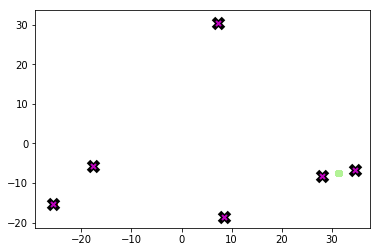

In [89]:
kmeans.plot_data(new_centroids, X.cpu().numpy(), n_samples)

In [90]:
# 